In [ ]:
"""
    -- Description:
        
        (1) This notebook shows a momentum based equity trading strategy, and evaluates the performance.
        
        (2) Momentum is expressed in the slope of exponential regression on the equity return, penalized by 
        
        the coefficient of determination, R^2.
        
        (3) The strategy will long the top-K performing equities based on momentum score, provided that the
        
        score meets a certain lower bond. Such a constraint acts as a downside protection.
        
        (4) Both commmission and slippage will be considered during simulation.
        
        
    -- Prerequisite:
        
        Quandl Data Ingestion
        
    -- Auther:
        
        Fang Fan (Roy)
        
    -- Date:
        
        August 28, 2020
    
"""

In [2]:
import zipline

from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, set_commission, set_slippage
from zipline.api import date_rules, time_rules, schedule_function, set_benchmark
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import  VolumeShareSlippage, FixedSlippage

from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

sns.set()
%matplotlib inline

In [3]:
# Model Setting
vol_window = 20
initial_portfolio = 100000
momentum_window = 125
minimum_momentum = 0.4
portfolio_size = 5

# Commission and Slippage Setting
enable_commission = True
commission_pct = 0.001

enable_slippage = True
slippage_volume_limit = 0.025
slippage_price_impact = 0.1

In [4]:
def momentum_score(ts):
    """
    Input: Price time series (pd.Series object)
    Output: Annualized exponential regression slope, multiplied by R^2
    """
    x = np.arange(len(ts))
    log_ts = np.log(ts)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    
    annualized_slope = np.exp(slope)**256 - 1
    score = annualized_slope * r_value ** 2
    
    return score

In [5]:
def volatility(ts):
    """
    Input: Price time series (pd.Series object)
    Output: latest rolling volatility, given the window size vol_window
    """
    return ts.pct_change(1).rolling(vol_window).std().iloc[-1]

In [6]:
def output_monthly_return(context):
    """
    Print monthly return during the backtest
    """
    today = zipline.api.get_datetime().date()
    
    current_value = context.portfolio.portfolio_value
    
    monthly_return = current_value / context.last_month - 1
    
    print("Date: {}\tLast Month Return: {:.2%}".format(today, monthly_return))
    
    context.last_month = current_value
    
    return None

In [7]:
def initialize(context):
    # Set commission and slippage
    if enable_commission:
        commission_model = PerDollar(commission_pct)
    else:
        commission_model = PerDollar(0.0)
        
    set_commission(commission_model)
    
    if enable_slippage:
        slippage_model = VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_price_impact)
    else:
        slippage_model = FixedSlippage(0.0)
    
    set_slippage(slippage_model)
    
    # Record Initial Portfolio Value
    context.last_month = initial_portfolio
    
    # Schedule monthly rebalance strategy
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())
    
    # For offline testing
    set_benchmark(False)

In [8]:
def rebalance(context, data):
    # Print last month's return
    output_monthly_return(context)
    
    # Trading Universe
    stocks = ["AAPL", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS",
                      "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "KO", 
                      "MCD", "MMM", "MRK", "MSFT", "NKE", "PFE", "PG", 
                      "TRV", "UNH", "UTX", "V", "VZ", "WBA", "WMT", "XOM"]
    todays_universe = [symbol(x) for x in stocks]
    
    # Get historical data, and calculate momentum score
    hist = data.history(todays_universe, "close", momentum_window, "1d")
    
    ranking_table = hist.apply(momentum_score, axis=0).sort_values(ascending=False)
    
    # Sell Logic: Close the positions if 
    # (1) the momentum score falls below the minimum requirement, or 
    # (2) if the equity doesn't belong to today's trading universe
    
    # Step 1: Close unwanted positions
    kept_positions = list(context.portfolio.positions.keys())
    for security in kept_positions:
        if security not in todays_universe:
            if data.can_trade(security):
                order_target_percent(security, 0)
                kept_positions.remove(security)
        elif ranking_table[security] < minimum_momentum:
            if data.can_trade(security):
                order_target_percent(security, 0)
                kept_positions.remove(security)
    
    # Step 2: Decide new equities to add in
    number_of_new_equities = portfolio_size - len(kept_positions)
    
    kept_equities_with_score = ranking_table[ranking_table.index.isin(kept_positions)]
    new_equities_with_score = ranking_table[~ranking_table.index.isin(kept_positions)][:number_of_new_equities]
    
    new_portfolio = pd.concat([kept_equities_with_score, new_equities_with_score])
    
    # Step 3: Decide the weight of each equity in the portfolio based on inverse volatility
    # Note that equities with momentum score under minimum_momentum won't be considered
    volatility_table = hist[new_portfolio.index].apply(volatility, axis=0)
    inv_volatility_table = 1 / volatility_table
    weights = inv_volatility_table / np.sum(inv_volatility_table)
    
    for security in new_portfolio.index:
        if security in kept_positions:
            if data.can_trade(security):
                order_target_percent(security, weights[security])
        elif ranking_table[security] >= minimum_momentum:
            if data.can_trade(security):
                order_target_percent(security, weights[security])

In [9]:
start_date = pd.to_datetime(datetime(2003, 1, 1, tzinfo=pytz.UTC))
end_date = pd.to_datetime(datetime(2017, 1, 1, tzinfo=pytz.UTC))

In [10]:
# Fire off the backtest
results = run_algorithm(start=start_date, 
                        end=end_date,
                        initialize=initialize,
                        handle_data=None,
                        analyze=None,
                        capital_base=initial_portfolio,
                        data_frequency="daily",
                        bundle="quandl",
                        before_trading_start=None,
                       )


Date: 2003-01-02	Last Month Return: 0.00%
Date: 2003-02-03	Last Month Return: -2.06%
Date: 2003-03-03	Last Month Return: -2.03%
Date: 2003-04-01	Last Month Return: -0.18%
Date: 2003-05-01	Last Month Return: 0.00%
Date: 2003-06-02	Last Month Return: 0.00%
Date: 2003-07-01	Last Month Return: -0.36%
Date: 2003-08-01	Last Month Return: -1.34%
Date: 2003-09-02	Last Month Return: 4.47%
Date: 2003-10-01	Last Month Return: 2.71%
Date: 2003-11-03	Last Month Return: 7.72%
Date: 2003-12-01	Last Month Return: 2.17%
Date: 2004-01-02	Last Month Return: 1.07%
Date: 2004-02-02	Last Month Return: -1.13%
Date: 2004-03-01	Last Month Return: 0.16%
Date: 2004-04-01	Last Month Return: -1.48%
Date: 2004-05-03	Last Month Return: -3.85%
Date: 2004-06-01	Last Month Return: 1.68%
Date: 2004-07-01	Last Month Return: 2.30%
Date: 2004-08-02	Last Month Return: -0.11%
Date: 2004-09-01	Last Month Return: 0.53%
Date: 2004-10-01	Last Month Return: 0.36%
Date: 2004-11-01	Last Month Return: 4.60%
Date: 2004-12-01	Last Mon

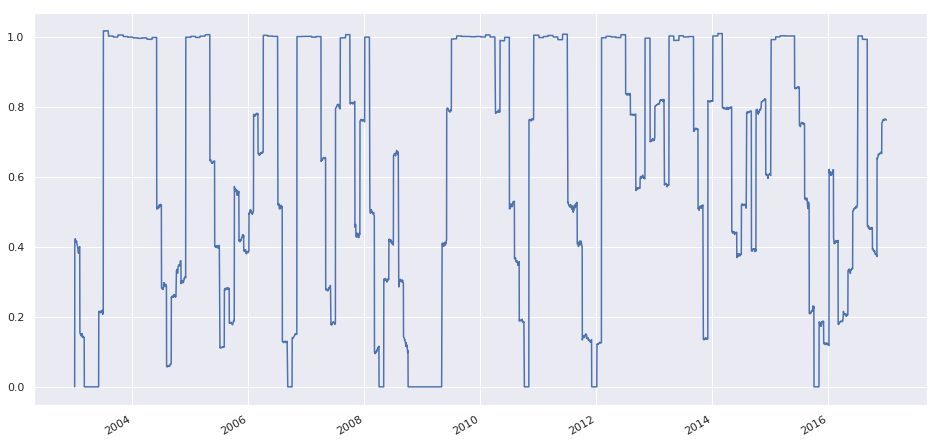

In [11]:
results["gross_leverage"].plot(figsize=(16, 8))

In [12]:
returns, positions, transactions, gross_leverage = pf.utils.extract_rets_pos_txn_from_zipline(results)

Entire data start date: 2003-01-02
Entire data end date: 2016-12-30


Backtest Months: 167


Performance statistics,Backtest
annual_return,0.05
annual_volatility,0.13
sharpe_ratio,0.47
calmar_ratio,0.21
stability_of_timeseries,0.93
max_drawdown,-0.26
omega_ratio,1.09
sortino_ratio,0.66
skew,-0.21
kurtosis,3.97


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,25.66,2007-11-06,2009-07-07,2009-10-12,505
1,17.09,2010-01-19,2010-07-02,2011-03-30,312
2,14.48,2004-01-16,2004-05-10,2004-11-22,222
3,12.38,2005-03-04,2005-10-21,2006-05-05,306
4,12.16,2006-05-09,2006-06-13,2007-01-11,178




[-0.016 -0.033]


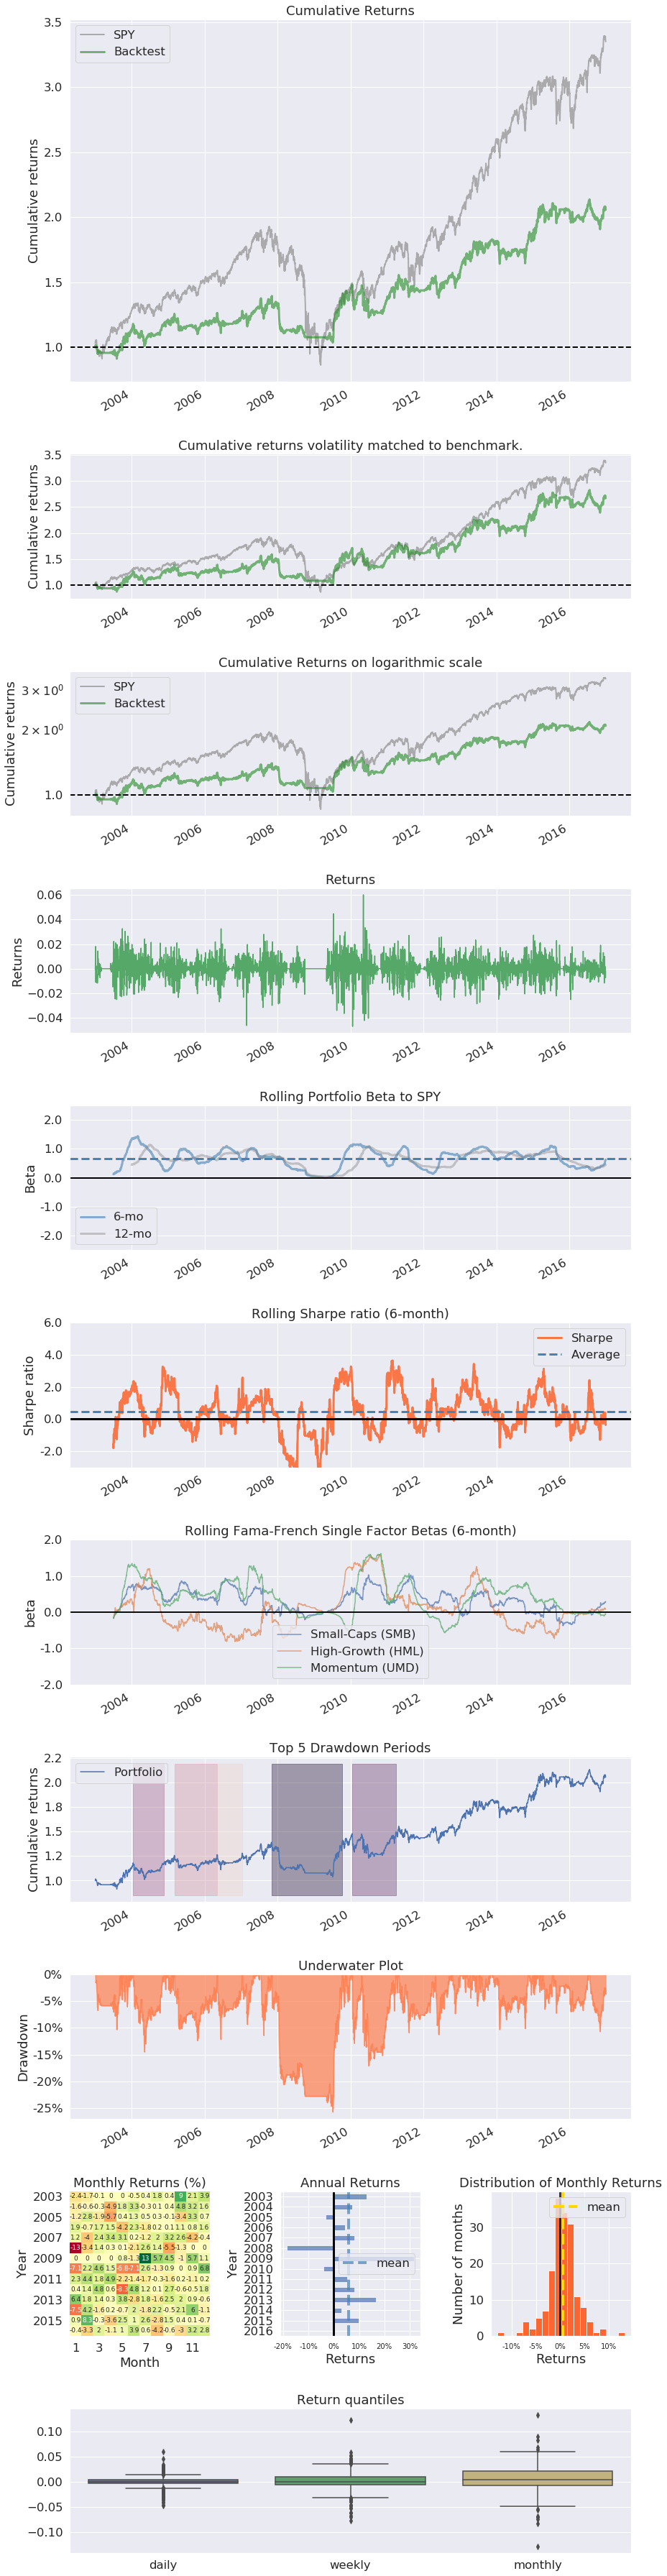

In [14]:
pf.create_returns_tear_sheet(returns=returns, benchmark_rets=None)